# GEONE - DEESSEX - Example II

The principle of deesseX is to fill the simulation grid by successively simulating sections with deesse (according the the given orientation) conditionally to the sections previously simulated. The name deesseX refers to crossing-simulation / X-simulation with deesse.

## Example - 3D simulation from 2D sections parallel to XY, XZ and YZ planes

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time
import os

# import package 'geone'
import geone as gn

In [2]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Read a 3D training image
Read a 3D (categorical) TI, from which sections will be extracted to perform deesseX simulation.

In [3]:
data_dir = 'data'
ti3d = gn.img.readImageTxt(os.path.join(data_dir, 'ti_3d.txt'))

# Category values and colors for further plots
categVal = [1, 2, 3] # list of category values / facies
categCol = ['pink', 'purple', 'yellow'] # colors for each category / facies

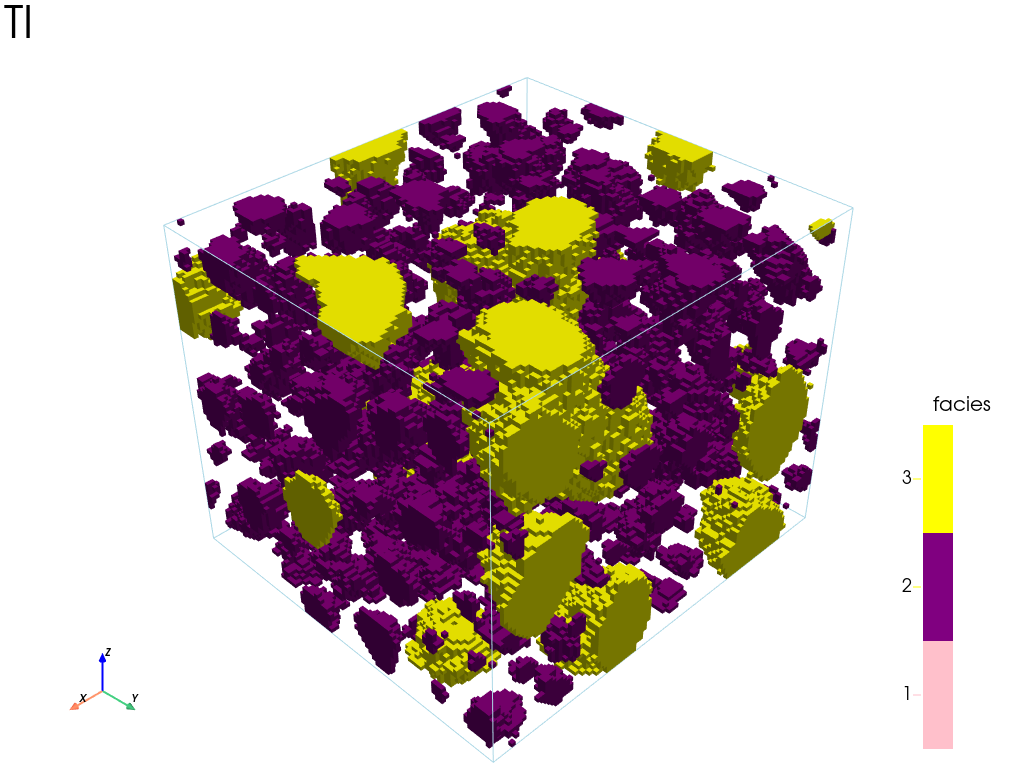

In [4]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()
gn.imgplot3d.drawImage3D_surface(
    ti3d, 
    plotter=pp, categ=True, categVal=categVal, categCol=categCol,
    categActive=[False, True, True], # display only category value (in categVal) with True
    alpha=1.0, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'facies', 'title_font_size':20, 'vertical':True},
    text='TI'
)
pp.show()

## DeesseX simulations based on XY, XZ and YZ-sections

### Extract 2D sections from the 3D TI to set the TIs for deesseX

For each orientation (XY, XZ, and YZ), extract some sections to define the TI for that orientation: we get a stack of 2D TIs (3D image).

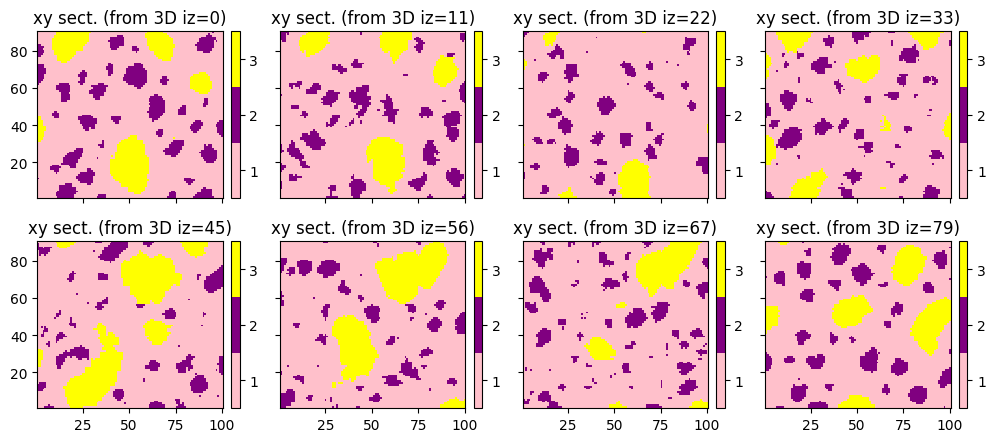

XY: TI dimension: 100 x 90 x 8  (stack of 8 2D TIs)


In [5]:
# Extract some sections for xy orientation
nsection_xy = 8
iz = np.asarray(np.linspace(0, ti3d.nz-1, nsection_xy), dtype='int') # section index

ti_xy = gn.img.Img(
    nx=ti3d.nx, ny=ti3d.ny, nz=nsection_xy,
    sx=ti3d.sx, sy=ti3d.sy, sz=ti3d.sz,
    ox=ti3d.ox, oy=ti3d.oy, oz=ti3d.oz,
    nv=1, varname='code', val=ti3d.val[:,iz,:,:]
)

# Figure
plt.subplots(2,4, figsize=(12,5),sharex=True, sharey=True)
for i in range(8):
    plt.subplot(2,4,i+1)
    gn.imgplot.drawImage2D(ti_xy, iz=i, categ=True, categVal=categVal, categCol=categCol)
    plt.title(f'xy sect. (from 3D iz={iz[i]})')

plt.show()

print(f'XY: TI dimension: {ti_xy.nx} x {ti_xy.ny} x {ti_xy.nz}  (stack of {ti_xy.nz} 2D TIs)')

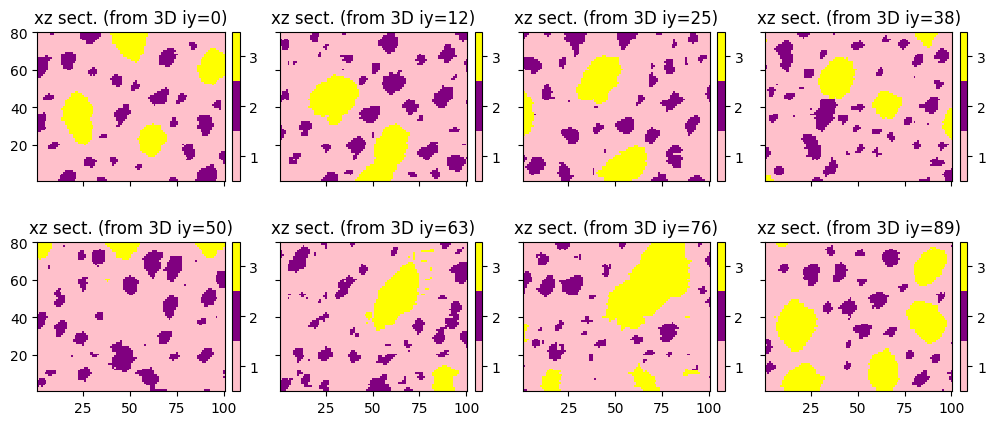

XZ: TI dimension: 100 x 8 x 80  (stack of 8 2D TIs)


In [6]:
# Extract some sections for xz orientation
nsection_xz = 8
iy = np.asarray(np.linspace(0, ti3d.ny-1, nsection_xz), dtype='int')

ti_xz = gn.img.Img(
    nx=ti3d.nx, ny=nsection_xz, nz=ti3d.nz,
    sx=ti3d.sx, sy=ti3d.sy, sz=ti3d.sz,
    ox=ti3d.ox, oy=ti3d.oy, oz=ti3d.oz,
    nv=1, varname='code', val=ti3d.val[:,:,iy,:]
)

# Figure
plt.subplots(2,4, figsize=(12,5),sharex=True, sharey=True)
for i in range(8):
    plt.subplot(2,4,i+1)
    gn.imgplot.drawImage2D(ti_xz, iy=i, categ=True, categVal=categVal, categCol=categCol)
    plt.title(f'xz sect. (from 3D iy={iy[i]})')

plt.show()

print(f'XZ: TI dimension: {ti_xz.nx} x {ti_xz.ny} x {ti_xz.nz}  (stack of {ti_xz.ny} 2D TIs)')

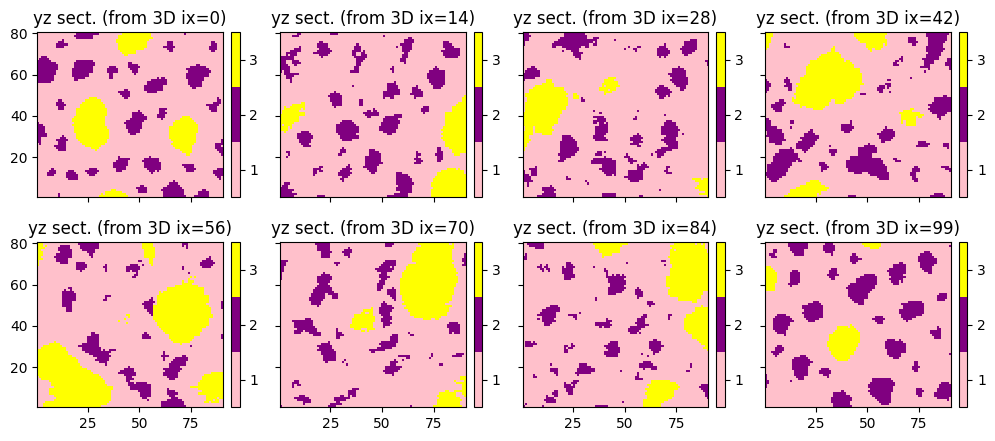

YZ: TI dimension: 8 x 90 x 80  (stack of 8 2D TIs)


In [7]:
# Extract some sections for yz orientation
nsection_yz = 8
ix = np.asarray(np.linspace(0, ti3d.nx-1, nsection_yz), dtype='int')

ti_yz = gn.img.Img(
    nx=nsection_yz, ny=ti3d.ny, nz=ti3d.nz,
    sx=ti3d.sx, sy=ti3d.sy, sz=ti3d.sz,
    ox=ti3d.ox, oy=ti3d.oy, oz=ti3d.oz,
    nv=1, varname='code', val=ti3d.val[:,:,:,ix]
)

# Figure
plt.subplots(2,4, figsize=(12,5),sharex=True, sharey=True)
for i in range(8):
    plt.subplot(2,4,i+1)
    gn.imgplot.drawImage2D(ti_yz, ix=i, categ=True, categVal=categVal, categCol=categCol)
    plt.title(f'yz sect. (from 3D ix={ix[i]})')

plt.show()

print(f'YZ: TI dimension: {ti_yz.nx} x {ti_yz.ny} x {ti_yz.nz}  (stack of {ti_yz.nx} 2D TIs)')

### Set up for deesseX

In [8]:
# sim grid 
nx, ny, nz = 80, 90, 78
sx, sy, sz = 1.0, 1.0, 1.0
ox, oy, oz = 0.0, 0.0, 0.0

# number of variables to be simulated, and their names
nv = 1
varname = 'code'
distanceType='categorical'

# Strategy of simulation
deesseX_input_section_path = gn.deesseinterface.DeesseXInputSectionPath(
    sectionMode='section_xy_xz_yz',
    sectionPathMode='section_path_subdiv'
)

# Deesse parameters for ...
# ... section parallel to xy plane
pyrGenParams_xy = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,                          # number of pyramid levels, additional to the simulation grid
    kx=[2, 2, 2], ky=[2, 2, 2], kz=[0, 0, 0]  # reduction factors from one level to the next one
                                              #    (kz=[0, 0, 0]: do not apply reduction along z axis)
)
pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=3,                        # number of levels
    pyramidType='categorical_auto'   # type of pyramid (accordingly to categorical variable in this example)
)
deesseX_input_section_xy = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='xy',           # section type for which the deesse parameters are defined
    TI=ti_xy,                   # TI (class gn.deesseinterface.Img)
    pyramidGeneralParameters=pyrGenParams_xy, # pyramid general parameters
    pyramidParameters=pyrParams,              # pyramid parameters for each variable
    nneighboringNode=64,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# ... section parallel to xz plane
pyrGenParams_xz = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,                          # number of pyramid levels, additional to the simulation grid
    kx=[2, 2, 2], ky=[0, 0, 0], kz=[2, 2, 2]  # reduction factors from one level to the next one
                                              #    (ky=[0, 0, 0]: do not apply reduction along y axis)
)
# (same pyramid paramters for variable)
deesseX_input_section_xz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='xz',           # section type for which the deesse parameters are defined
    TI=ti_xz,                   # TI (class gn.deesseinterface.Img)
    pyramidGeneralParameters=pyrGenParams_xz, # pyramid general parameters
    pyramidParameters=pyrParams,              # pyramid parameters for each variable
    nneighboringNode=64,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# ... section parallel to yz plane
pyrGenParams_yz = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,                          # number of pyramid levels, additional to the simulation grid
    kx=[0, 0, 0], ky=[2, 2, 2], kz=[2, 2, 2]  # reduction factors from one level to the next one
                                              #    (kx=[0, 0, 0]: do not apply reduction along x axis)
)
# (same pyramid paramters for variable)
deesseX_input_section_yz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='yz',           # section type for which the deesse parameters are defined
    TI=ti_yz,                   # TI (class gn.deesseinterface.Img)
    pyramidGeneralParameters=pyrGenParams_yz, # pyramid general parameters
    pyramidParameters=pyrParams,              # pyramid parameters for each variable
    nneighboringNode=64,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# Main input for deesseX
deesseX_input = gn.deesseinterface.DeesseXInput(
    nx=nx, ny=ny, nz=nz,        # dimension of the simulation grid (number of cells)
    sx=sx, sy=sy, sz=sz,        # cells units in the simulation grid (here are the default values)
    ox=ox, oy=oy, oz=oz,        # origin of the simulation grid (here are the default values)
    nv=nv, varname=varname,     # number of variable(s), name of the variable(s)
    distanceType=distanceType,  # distance type: proportion of mismatching nodes (categorical var., default)
    sectionPath_parameters=deesseX_input_section_path, 
                                # section path (defining the succession of section to be simulated)
                                # (class gn.deesseinterface.DeesseXInputSectionPath)
    section_parameters=[deesseX_input_section_xy, deesseX_input_section_xz, deesseX_input_section_yz],
                                # simulation parameters for each section type
                                # (sequence of class gn.deesseinterface.DeesseXInputSection)
    outputSectionTypeFlag=True, # retrieve section type map in output
    outputSectionStepFlag=True, # retrieve section step map in output
    seed=444,                   # seed (initialization of the random number generator)
    nrealization=2)             # number of realization(s)

### Launching deesseX

In [9]:
# Run deesseX
t1 = time.time() # start time
deesseX_output = gn.deesseinterface.deesseXRun_mp(deesseX_input, nproc=2, nthreads_per_proc=9)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSseX running on 2 process(es)... [VERSION 1.0 / BUILD NUMBER 20230914 / OpenMP 9 thread(s)]
DeeSseX run complete (all process(es))
Elapsed time: 66 sec


### Retrieve the results (and display)

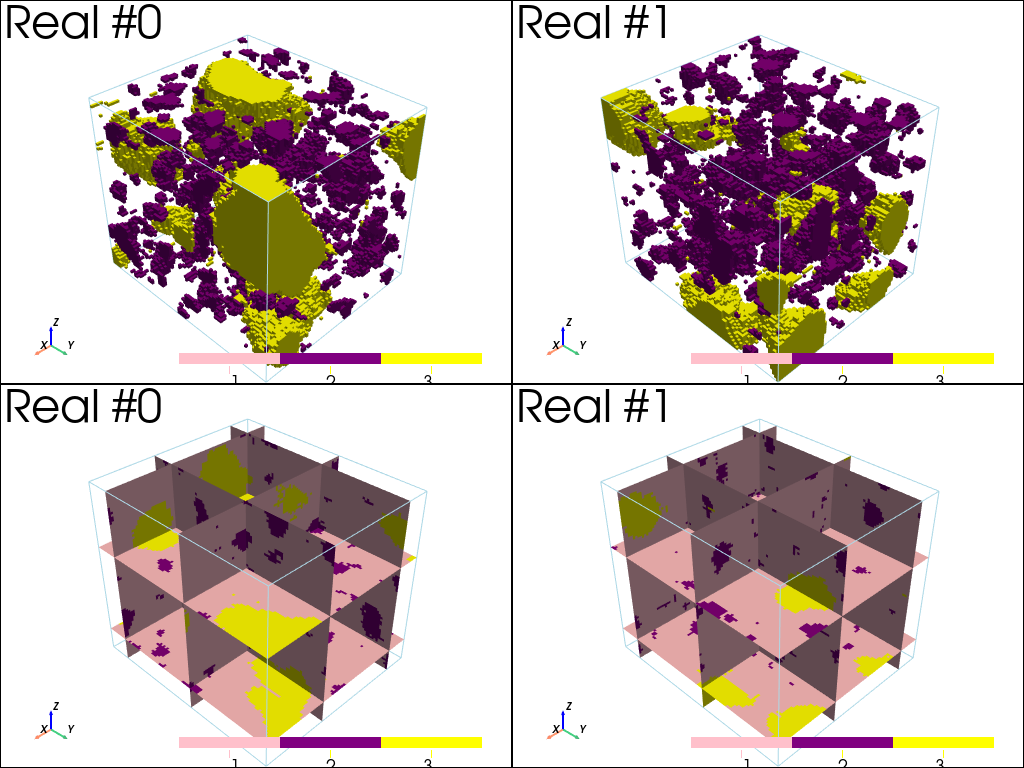

In [10]:
# Retrieve results
sim = deesseX_output['sim']

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

for i in range(2):
    pp.subplot(0,i)
    gn.imgplot3d.drawImage3D_surface(
        sim[i], 
        plotter=pp,
        categ=True,
        categVal=categVal,
        categCol=categCol,
        categActive=[False, True, True], # display only category value (in categVal) with True
        alpha=1.0, # transparency (alpha channel)
        scalar_bar_kwargs={'title':(i+1)*' ', 'vertical':False}, # distinct title in each subplot 
                                                                 #    for correct display!
        text=f'Real #{i}')

for i in range(2):
    pp.subplot(1,i)
    gn.imgplot3d.drawImage3D_slice(
        sim[i], 
        plotter=pp,
        slice_normal_x=[10, 50], 
        slice_normal_y=[10, 50],
        slice_normal_z=[10, 50],
        categ=True,
        categVal=categVal,
        categCol=categCol,
        alpha=1.0, # transparency (alpha channel)
        scalar_bar_kwargs={'title':(i+3)*' ', 'vertical':False}, # distinct title in each subplot 
                                                                 #    for correct display!
        text=f'Real #{i}')

pp.link_views()
pp.show()

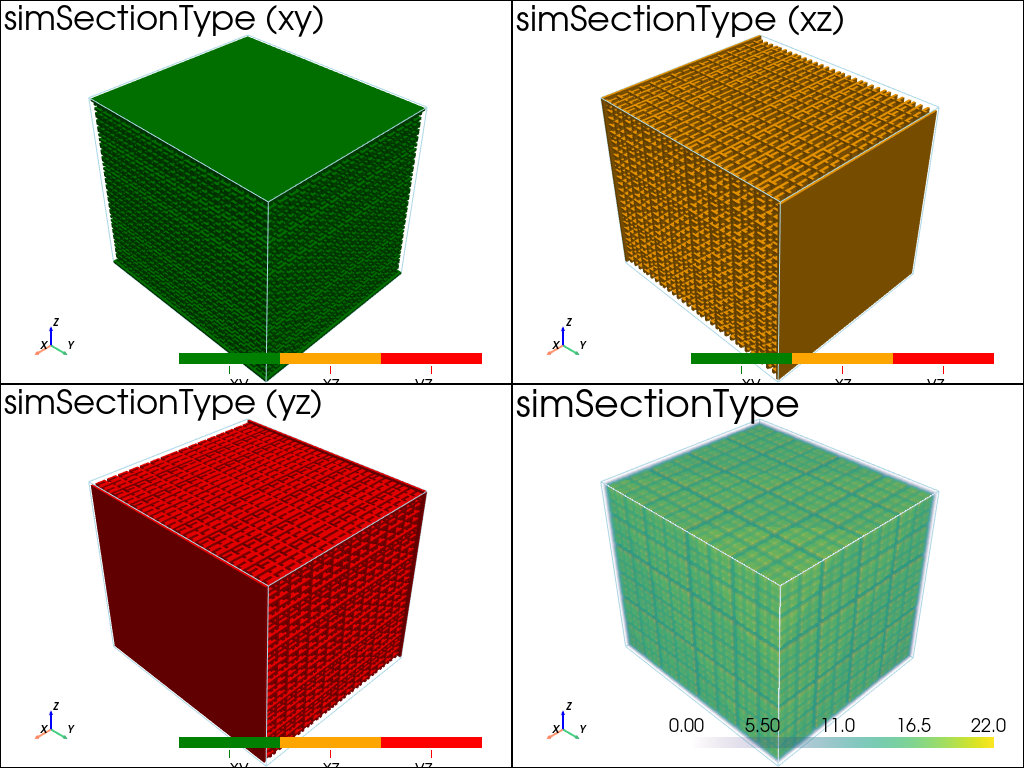

In [11]:
# Retrieve simSectionType and simSectionStep
simSectionType = deesseX_output['simSectionType'][0] # only one section type map
simSectionStep = deesseX_output['simSectionStep'][0] # only one section step map

# value and color of section type 
categValSectType = [0, 1, 2] # value of the section type id (0: xy, 1: xz, 2: yz)
categColSectType = ['green', 'orange', 'red'] # color for section type

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

for i, (active, type_str) in enumerate(zip(
        [[True, False, False], [False, True, False], [False, False, True]], ['xy', 'xz', 'yz']
    )):
    pp.subplot(i//2,i%2)
    gn.imgplot3d.drawImage3D_surface(
        simSectionType, 
        plotter=pp,
        categ=True,
        categVal=categValSectType,
        categCol=categColSectType,
        categActive=active, # display only category value (in categVal) with True
        alpha=1, # transparency (alpha channel)
        scalar_bar_annotations={0.5:'xy', 1.5:'xz', 2.5:'yz'}, # (add 0.5 to center the label)
        scalar_bar_kwargs={'title':(i+1)*' ', 'vertical':False}, # distinct title in each subplot 
                                                                 #    for correct display!
        text=f'simSectionType ({type_str})')

pp.subplot(1,1)
gn.imgplot3d.drawImage3D_volume(simSectionStep, plotter=pp,
    scalar_bar_kwargs={'title':5*' ', 'vertical':False}, # distinct title in each subplot for correct display!
    text='simSectionType')

pp.link_views()
pp.show()

## DeesseX simulations based on XY-section (2D) and Z-section (1D)

### Extract sections from the 3D TI to set the TIs for deesseX

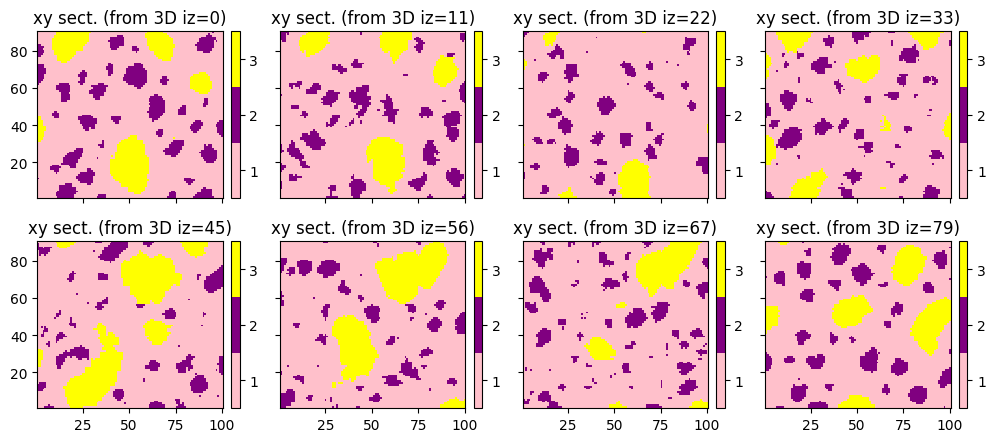

XY: TI dimension: 100 x 90 x 8  (stack of 8 2D TIs)


In [12]:
# Extract some sections for xy orientation (as above)
nsection_xy = 8
iz = np.asarray(np.linspace(0, ti3d.nz-1, nsection_xy), dtype='int') # section index

ti_xy = gn.img.Img(
    nx=ti3d.nx, ny=ti3d.ny, nz=nsection_xy,
    sx=ti3d.sx, sy=ti3d.sy, sz=ti3d.sz,
    ox=ti3d.ox, oy=ti3d.oy, oz=ti3d.oz,
    nv=1, varname='code', val=ti3d.val[:,iz,:,:]
)

# Figure
plt.subplots(2,4, figsize=(12,5),sharex=True, sharey=True)
for i in range(8):
    plt.subplot(2,4,i+1)
    gn.imgplot.drawImage2D(ti_xy, iz=i, categ=True, categVal=categVal, categCol=categCol)
    plt.title(f'xy sect. (from 3D iz={iz[i]})')

plt.show()

print(f'XY: TI dimension: {ti_xy.nx} x {ti_xy.ny} x {ti_xy.nz}  (stack of {ti_xy.nz} 2D TIs)')

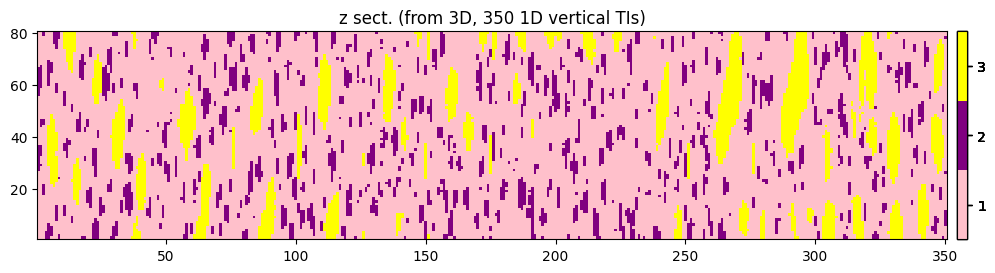

Z: TI dimension: 350 x 1 x 80   (350 1D TIs)


In [13]:
# Extract some sections for z orientation
nsection_z_ix = 25
nsection_z_iy = 14

nsection_z = nsection_z_ix * nsection_z_iy

iy, ix = np.asarray(
            np.meshgrid(np.linspace(0, ti3d.ny-1, nsection_z_iy),
                        np.linspace(0, ti3d.nx-1, nsection_z_ix), indexing='ij'),
            dtype='int')

# Set stack of 1D TIs in 3D
#ti_z = gn.img.Img(
#    nx=nsection_z_ix, ny=nsection_z_iy, nz=ti3d.nz,
#    sx=ti3d.sx, sy=ti3d.sy, sz=ti3d.sz,
#    ox=ti3d.ox, oy=ti3d.oy, oz=ti3d.oz,
#    nv=1, varname='code', val=ti3d.val[:,:,iy, ix]
#)

# Set stack of 1D TIs in 2D (equiv., more practical for plotting just below)
ti_z = gn.img.Img(
    nx=nsection_z, ny=1, nz=ti3d.nz,
    sx=ti3d.sx, sy=ti3d.sy, sz=ti3d.sz,
    ox=ti3d.ox, oy=ti3d.oy, oz=ti3d.oz,
    nv=1, varname='code', val=ti3d.val[:,:,iy, ix]
)


# Figure
plt.figure(figsize=(12,5))
for i in range(8):
    gn.imgplot.drawImage2D(ti_z, iy=0, categ=True, categVal=categVal, categCol=categCol)
    plt.title(f'z sect. (from 3D, {nsection_z} 1D vertical TIs)')

plt.show()

print(f'Z: TI dimension: {ti_z.nx} x {ti_z.ny} x {ti_z.nz}   ({nsection_z} 1D TIs)')

### Set up for deesseX

In [14]:
# sim grid 
nx, ny, nz = 80, 90, 78
sx, sy, sz = 1.0, 1.0, 1.0
ox, oy, oz = 0.0, 0.0, 0.0

# number of variables to be simulated, and their names
nv = 1
varname = 'code'
distanceType='categorical'

# Strategy of simulation
deesseX_input_section_path = gn.deesseinterface.DeesseXInputSectionPath(
    sectionMode='section_xy_z',
    sectionPathMode='section_path_subdiv'
)

# Deesse parameters for ...
# ... section parallel to xy plane
pyrGenParams_xy = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,                          # number of pyramid levels, additional to the simulation grid
    kx=[2, 2, 2], ky=[2, 2, 2], kz=[0, 0, 0]  # reduction factors from one level to the next one
                                              #    (kz=[0, 0, 0]: do not apply reduction along z axis)
)
pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=3,                        # number of levels
    pyramidType='categorical_auto'   # type of pyramid (accordingly to categorical variable in this example)
)
deesseX_input_section_xy = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='xy',           # section type for which the deesse parameters are defined
    TI=ti_xy,                   # TI (class gn.deesseinterface.Img)
    pyramidGeneralParameters=pyrGenParams_xy, # pyramid general parameters
    pyramidParameters=pyrParams,              # pyramid parameters for each variable
    nneighboringNode=64,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# ... section parallel to z axis
pyrGenParams_z = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=3,                          # number of pyramid levels, additional to the simulation grid
    kx=[0, 0, 0], ky=[0, 0, 0], kz=[2, 2, 2]  # reduction factors from one level to the next one
                                              #    (kx=ky=[0, 0, 0]: do not apply reduction along x,y axes)
)
# (same pyramid paramters for variable)
deesseX_input_section_z = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='z',            # section type for which the deesse parameters are defined
    TI=ti_z,                    # TI (class gn.deesseinterface.Img)
    pyramidGeneralParameters=pyrGenParams_z, # pyramid general parameters
    pyramidParameters=pyrParams,             # pyramid parameters for each variable
    nneighboringNode=64,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# Main input for deesseX
deesseX_input = gn.deesseinterface.DeesseXInput(
    nx=nx, ny=ny, nz=nz,        # dimension of the simulation grid (number of cells)
    sx=sx, sy=sy, sz=sz,        # cells units in the simulation grid (here are the default values)
    ox=ox, oy=oy, oz=oz,        # origin of the simulation grid (here are the default values)
    nv=nv, varname=varname,     # number of variable(s), name of the variable(s)
    distanceType=distanceType,  # distance type: proportion of mismatching nodes (categorical var., default)
    sectionPath_parameters=deesseX_input_section_path, 
                                # section path (defining the succession of section to be simulated)
                                # (class gn.deesseinterface.DeesseXInputSectionPath)
    section_parameters=[deesseX_input_section_xy, deesseX_input_section_z],
                                # simulation parameters for each section type
                                # (sequence of class gn.deesseinterface.DeesseXInputSection)
    outputSectionTypeFlag=True, # retrieve section type map in output
    outputSectionStepFlag=True, # retrieve section step map in output
    seed=444,                   # seed (initialization of the random number generator)
    nrealization=2)             # number of realization(s)

### Launching deesseX

In [15]:
# Run deesseX
t1 = time.time() # start time
deesseX_output = gn.deesseinterface.deesseXRun_mp(deesseX_input, nproc=2, nthreads_per_proc=9)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSseX running on 2 process(es)... [VERSION 1.0 / BUILD NUMBER 20230914 / OpenMP 9 thread(s)]
DeeSseX run complete (all process(es))
Elapsed time: 84 sec


### Retrieve the results (and display)

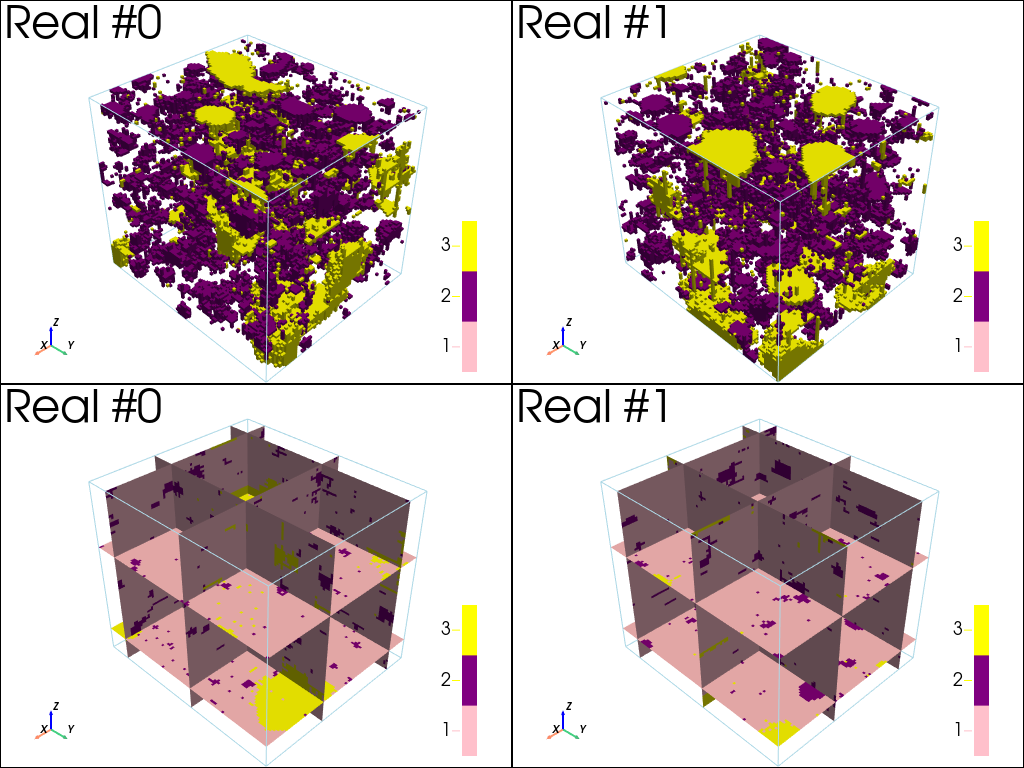

In [16]:
# Retrieve results
sim = deesseX_output['sim']

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

for i in range(2):
    pp.subplot(0,i)
    gn.imgplot3d.drawImage3D_surface(
        sim[i], 
        plotter=pp,
        categ=True,
        categVal=categVal,
        categCol=categCol,
        categActive=[False, True, True], # display only category value (in categVal) with True
        alpha=1.0, # transparency (alpha channel)
        scalar_bar_kwargs={'title':(i+1)*' ', 'vertical':True}, # distinct title in each subplot 
                                                                #    for correct display!
        text=f'Real #{i}')

for i in range(2):
    pp.subplot(1,i)
    gn.imgplot3d.drawImage3D_slice(
        sim[i], 
        plotter=pp,
        slice_normal_x=[10, 50], 
        slice_normal_y=[10, 50],
        slice_normal_z=[10, 50],
        categ=True,
        categVal=categVal,
        categCol=categCol,
        alpha=1.0, # transparency (alpha channel)
        scalar_bar_kwargs={'title':(i+3)*' ', 'vertical':True}, # distinct title in each subplot 
                                                                 #    for correct display!
        text=f'Real #{i}')

pp.link_views()
pp.show()

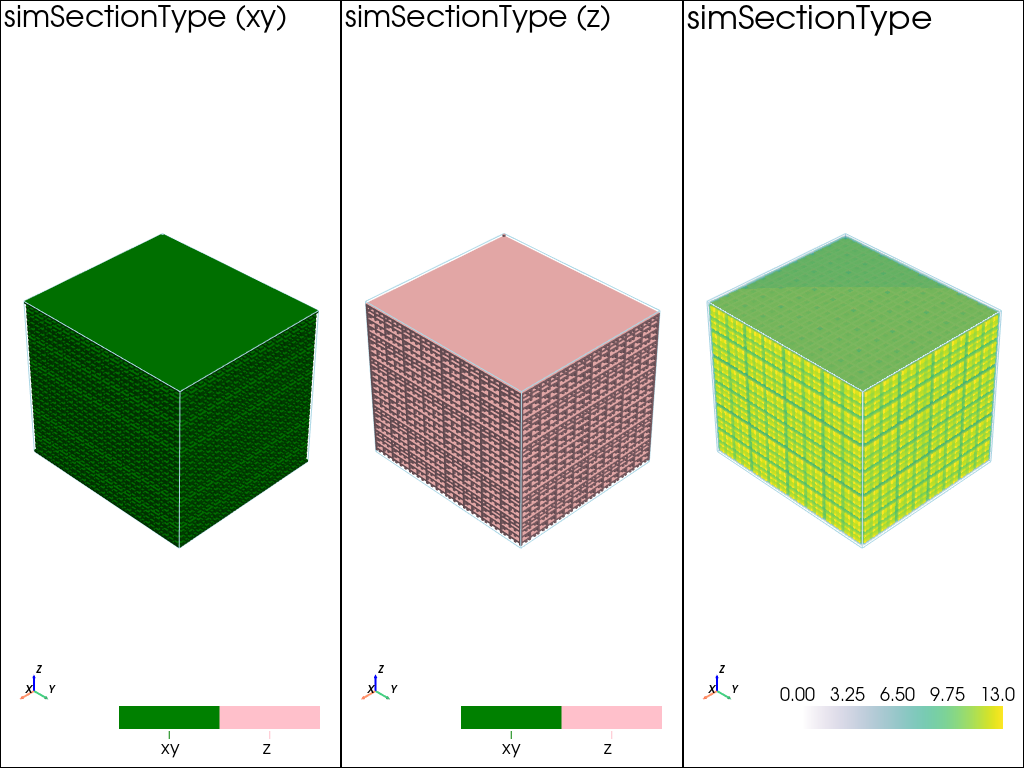

In [17]:
# Retrieve simSectionType and simSectionStep
simSectionType = deesseX_output['simSectionType'][0] # only one section type map
simSectionStep = deesseX_output['simSectionStep'][0] # only one section step map

# value and color of section type 
categValSectType = [0, 3] # value of the section type id (0: xy, 3: z)
categColSectType = ['green', 'pink'] # color for section type

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,3))

for i, (active, type_str) in enumerate(zip(
        [[True, False], [False, True]], ['xy', 'z']
    )):
    pp.subplot(0,i)
    gn.imgplot3d.drawImage3D_surface(
        simSectionType, 
        plotter=pp,
        categ=True,
        categVal=categValSectType,
        categCol=categColSectType,
        categActive=active, # display only category value (in categVal) with True
        alpha=1, # transparency (alpha channel)
        scalar_bar_annotations={0.5:'xy', 1.5:'z'}, # (add 0.5 to center the label)
        scalar_bar_kwargs={'title':(i+1)*' ', 'vertical':False}, # distinct title in each subplot 
                                                                 #    for correct display!
        text=f'simSectionType ({type_str})')

pp.subplot(0,2)
gn.imgplot3d.drawImage3D_volume(
    simSectionStep, 
    plotter=pp,
    scalar_bar_kwargs={'title':5*' ', 'vertical':False}, # distinct title in each subplot for correct display!
    text='simSectionType')

pp.link_views()
pp.show()